In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import sqrt

import os,sys
import time, csv
import random
from collections import Counter

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.Draw import IPythonConsole
# from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# print(plt.style.available)
plt.style.use('ggplot')

In [4]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
seed_set()

In [7]:
df = pd.read_csv('virdis_solu_final_5.csv')

In [8]:
# make sure there are no duplicates
df['smiles'].nunique()

2418

In [9]:
df.head()
#df.describe()

,smiles,log_sol
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860
1,C(CCl)Cl,-1.060961
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497
4,C1=CC(=CC(=C1)O)C=O,-1.230058


Text(0, 0.5, 'Count')

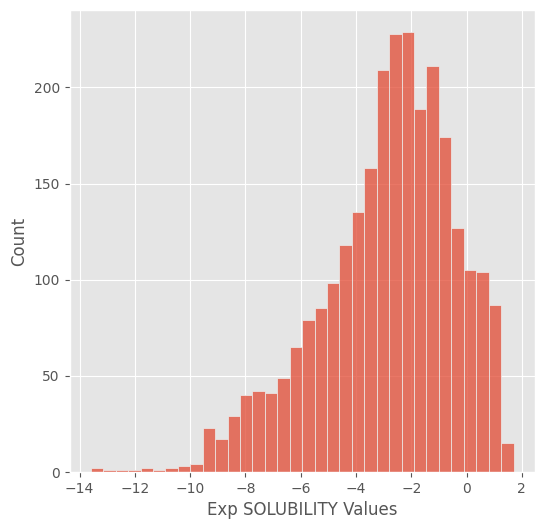

In [11]:
# distribution of exp lipophilicity values
plt.figure(figsize=(6,6))
sns.histplot(data=df, x='log_sol', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Exp SOLUBILITY Values')
plt.ylabel('Count')

In [12]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')

In [13]:
df.head()

,smiles,log_sol,mol
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860,<rdkit.Chem.rdchem.Mol object at 0x7f547d54ea40>
1,C(CCl)Cl,-1.060961,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e810>
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441,<rdkit.Chem.rdchem.Mol object at 0x7f547d54d8c0>
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e960>
4,C1=CC(=CC(=C1)O)C=O,-1.230058,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e260>


In [14]:
mwt = []
for mol in df['mol']:
  MW = Descriptors.MolWt(mol)
  mwt.append(MW)

df['molwt'] = mwt

In [15]:
df.head()

,smiles,log_sol,mol,molwt
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860,<rdkit.Chem.rdchem.Mol object at 0x7f547d54ea40>,202.553
1,C(CCl)Cl,-1.060961,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e810>,98.960
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441,<rdkit.Chem.rdchem.Mol object at 0x7f547d54d8c0>,181.449
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e960>,163.003
4,C1=CC(=CC(=C1)O)C=O,-1.230058,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e260>,122.123


Text(0, 0.5, 'Count')

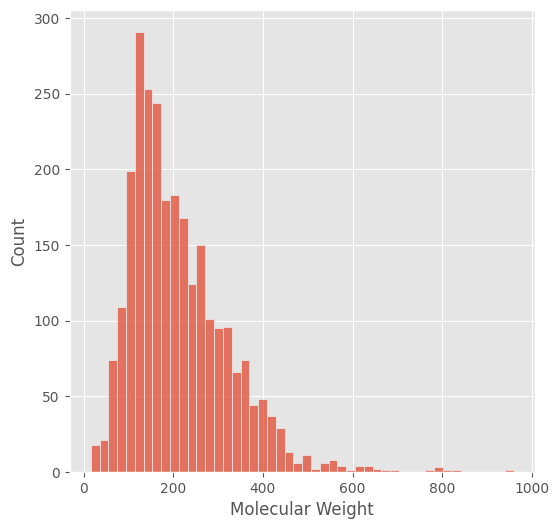

In [16]:
# Distribution of Molecular Weight in Raw Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [17]:
high_mwt = df[df['molwt'] > 700]
high_mwt

,smiles,log_sol,mol,molwt
1338,C1(=C(C(=C(C(=C1Br)Br)Br)Br)Br)OC2=C(C(=C(C(=C...,-9.981909,<rdkit.Chem.rdchem.Mol object at 0x7f547ab19850>,959.171
1592,C1=CC=C(C(=C1)C2=C3C=C(C(=O)C(=C3OC4=C(C(=C(C=...,-0.967912,<rdkit.Chem.rdchem.Mol object at 0x7f547ab20890>,835.895
2172,C1=C(C(=C(C(=C1Br)Br)Br)Br)C2=CC(=C(C(=C2Br)Br...,-9.351023,<rdkit.Chem.rdchem.Mol object at 0x7f547ab30890>,785.380
2304,CC1C(C(CC(O1)OC2C(OC(CC2O)OC3C(OC(CC3O)OC4CCC5...,-2.901404,<rdkit.Chem.rdchem.Mol object at 0x7f547ab342e0>,796.948
2309,CC(=O)NC1=C(C(=C(C(=C1I)C(=O)NC2C(C(C(OC2O)CO)...,-0.198162,<rdkit.Chem.rdchem.Mol object at 0x7f547ab34510>,789.099
2422,CC1C(C(CC(O1)OC2C(OC(CC2O)OC3C(OC(CC3O)OC4CCC5...,-4.081020,<rdkit.Chem.rdchem.Mol object at 0x7f547ab37680>,780.949
2662,CCOC(=O)C(CC1=CC(=C(C(=C1)I)OC2=CC(=C(C(=C2)I)...,-4.604723,<rdkit.Chem.rdchem.Mol object at 0x7f547ab3e0a0>,804.926


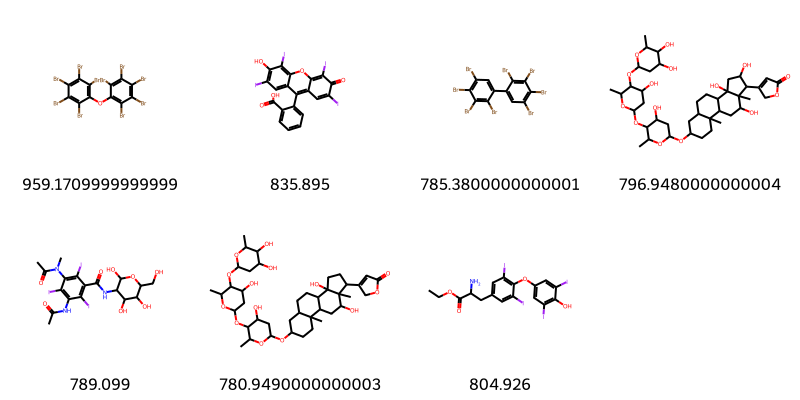

In [18]:
img=Draw.MolsToGridImage(high_mwt['mol'], molsPerRow=4, subImgSize=(200,200),legends=[str(x) for x in high_mwt['molwt']])
img

In [19]:
smiles = high_mwt['smiles']
df_final = df[~df['smiles'].isin(smiles)]
df_final.head()

,smiles,log_sol,mol,molwt
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860,<rdkit.Chem.rdchem.Mol object at 0x7f547d54ea40>,202.553
1,C(CCl)Cl,-1.060961,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e810>,98.960
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441,<rdkit.Chem.rdchem.Mol object at 0x7f547d54d8c0>,181.449
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e960>,163.003
4,C1=CC(=CC(=C1)O)C=O,-1.230058,<rdkit.Chem.rdchem.Mol object at 0x7f547d54e260>,122.123


In [20]:
df_final.shape

(2667, 4)

In [25]:
# df_final = df_final[['smiles', 'log_sol']]
# df_final.to_csv('delaney_final.csv', index=None)

Text(0, 0.5, 'Count')

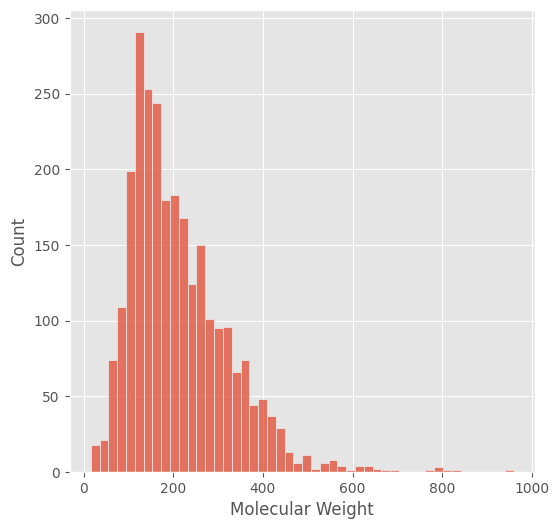

In [21]:
# Distribution of Molecular Weight in Truncated Dataset
plt.figure(figsize=(6,6))
sns.histplot(data=df, x = 'molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [22]:
# df_final = df_final.reset_index(drop=True)

In [23]:
unique_atoms = set()
for mol in df['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    unique_atoms.add(a)
unique_atoms

{'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'}

In [24]:
atom_list = []
for mol in df['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    atom_list.append(a)
Counter(atom_list)

Counter({'C': 26044,
         'O': 5230,
         'N': 2082,
         'Cl': 1662,
         'F': 493,
         'S': 388,
         'Br': 204,
         'P': 88,
         'I': 61})

In [25]:
dict_ = { 'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1}

df_freq = pd.DataFrame(dict_.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)
df_freq.head()

,Atoms,Count
0,N,14505
2,O,10679
4,F,1760
3,S,1580
1,Cl,1288


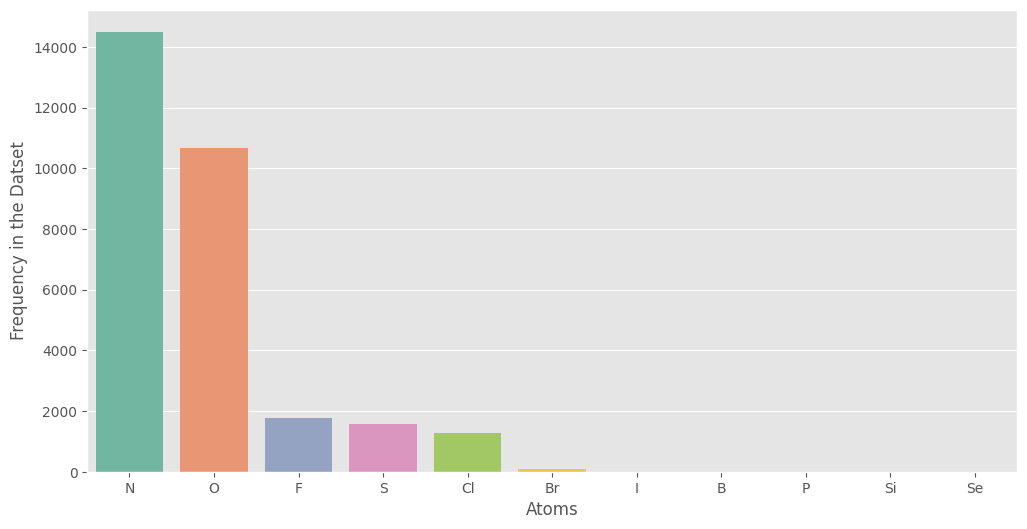

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq, x = 'Atoms', y = 'Count', hue = 'Atoms', palette = 'Set2', legend = False)
plt.ylabel('Frequency in the Datset')
plt.show()

In [27]:
atom_list = ['B', 'Br','Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']
dict_2 = {}
for i in range(len(atom_list)):
  count=0
  for mol in df["mol"]:
    all_atoms = set()
    for atom in mol.GetAtoms():
      a = atom.GetSymbol()
      all_atoms.add(a)
    if atom_list[i] in all_atoms:
      count+=1
    dict_2[atom_list[i]] = count
dict_2

{'B': 0,
 'Br': 110,
 'Cl': 595,
 'F': 154,
 'I': 36,
 'N': 1098,
 'O': 1889,
 'P': 85,
 'S': 293,
 'Se': 0,
 'Si': 0}

In [28]:
df_freq_2 = pd.DataFrame(dict_2.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

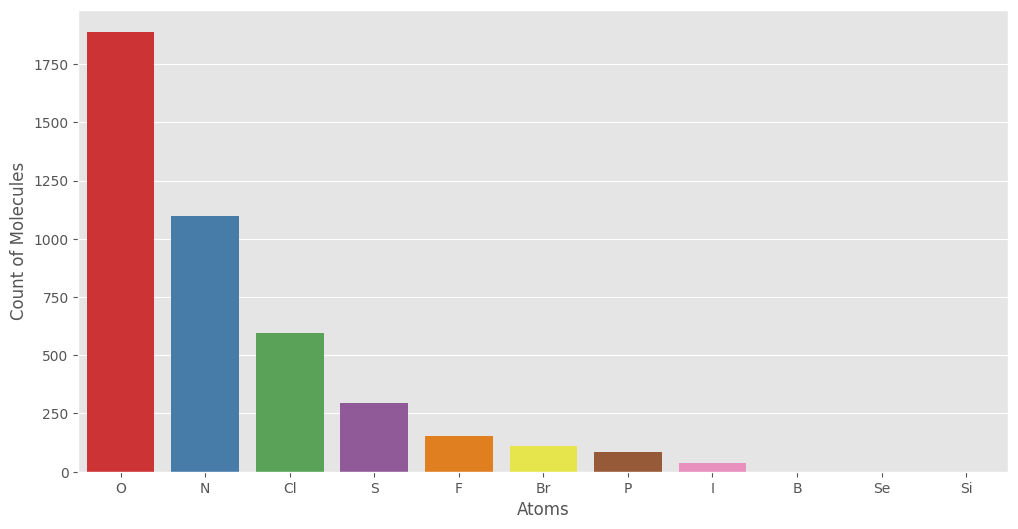

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', hue = 'Atoms', palette = 'Set1')
plt.ylabel('Count of Molecules')
plt.show()

In [30]:
atom_list = ['B', 'Br','Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']
dict_2 = {}
for i in range(len(atom_list)):
  count=0
  for mol in df["mol"]:
    all_atoms = set()
    for atom in mol.GetAtoms():
      a = atom.GetSymbol()
      all_atoms.add(a)
    if atom_list[i] in all_atoms:
      count+=1
    dict_2[atom_list[i]] = count
dict_2

{'B': 0,
 'Br': 110,
 'Cl': 595,
 'F': 154,
 'I': 36,
 'N': 1098,
 'O': 1889,
 'P': 85,
 'S': 293,
 'Se': 0,
 'Si': 0}

In [31]:
df_freq_2 = pd.DataFrame(dict_2.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

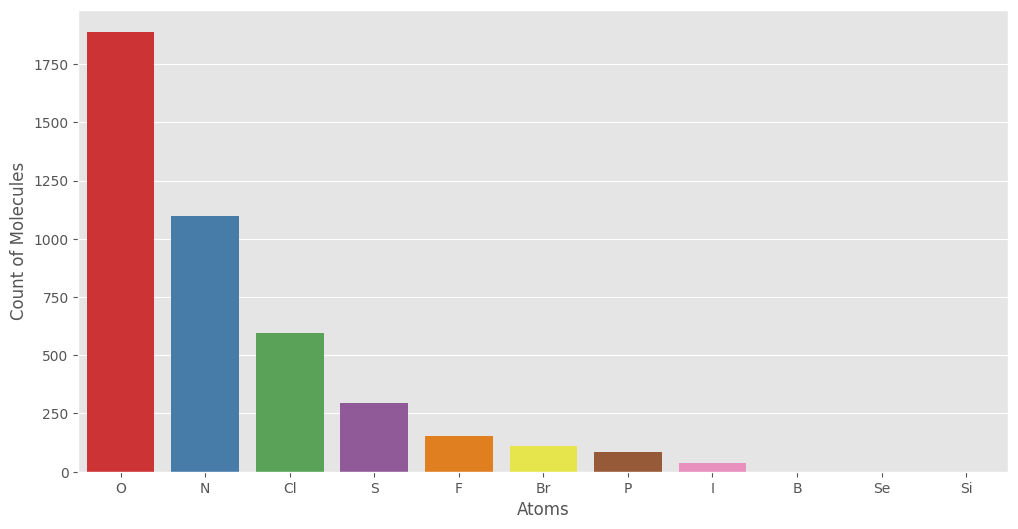

In [33]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', hue = 'Atoms', palette = 'Set1')
plt.ylabel('Count of Molecules')
plt.show()